In [1]:
from __future__ import print_function
import os
import keras
import pickle as pk
import numpy as np
import keras.layers as kl
import keras.backend as K
import tensorflow as tf
from keras.engine import Layer
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.utils.vis_utils import plot_model
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [130]:
print(keras.__version__)
print(tf.__version__)

2.3.1
1.15.0


In [124]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    for i in tqdm(range(X.shape[0])):
        # plot colored number
        if d[i] == 0:
            color = 'green'
        elif d[i] == 1:
            color = 'purple'
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=color,
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

In [6]:
def reverse_gradient(X, hp_lambda):
    '''Flips the sign of the incoming gradient during training.'''
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]

    g = K.get_session().graph
    with g.gradient_override_map({'Identity': grad_name}):
        y = tf.identity(X)

    return y

class GradientReversal(Layer):
    '''Flip the sign of gradient during training.'''
    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights.append([])

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def get_config(self):
        config = {}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [106]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    
# Process MNIST
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = mnist_train[:2000]
trainX = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = mnist_test[:500]
testX = np.concatenate([mnist_test, mnist_test, mnist_test], 3)

# Load MNIST-M dataset as out-of-domain and unlabeled data
with open('./MNIST_data/mnistm_data.pkl', 'rb') as f:
	mnistm = pk.load(f)
trainDX = mnistm['train'][:2000]
testDX = mnistm['test'][:500]

trainY = mnist.train.labels[:2000]
testY = mnist.test.labels[:500]
# Rescale -1 to 1
trainX = trainX.astype(np.float32)/255.
trainDX = trainDX.astype(np.float32)/255.
testX = testX.astype(np.float32)/255.
testDX = testDX.astype(np.float32)/255.

trainX_domain = np.tile([1., 0.], [len(trainX), 1])
trainDX_domain = np.tile([0., 1.], [len(trainDX),1])

testX_domain = np.tile([1., 0.], [len(testX), 1])
testDX_domain = np.tile([0., 1.], [len(testDX),1])

print(trainX.shape,trainDX.shape,testX.shape,testDX.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(2000, 28, 28, 3) (2000, 28, 28, 3) (500, 28, 28, 3) (500, 28, 28, 3)


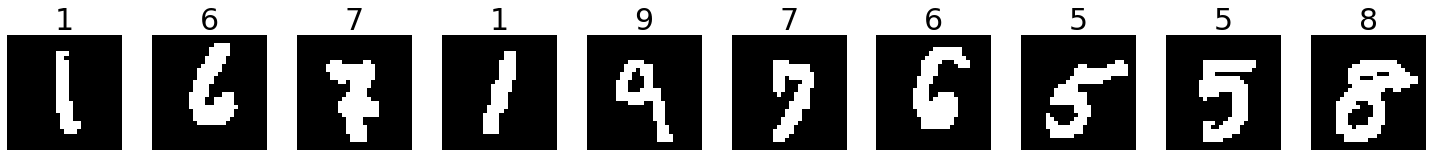

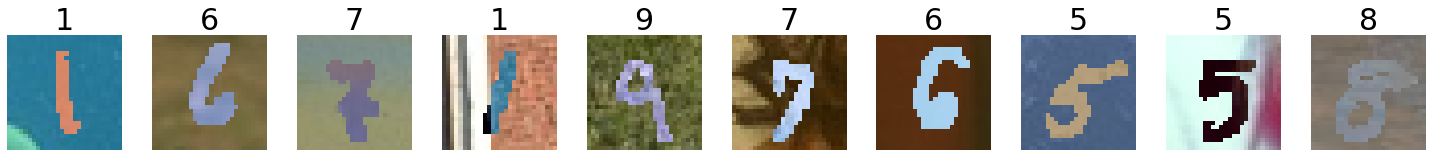

In [107]:
c=0
plt.figure(figsize=(20,3))
for i in range(20,30):
    plt.subplot(1,10,c+1)
    plt.imshow(trainX[i])
    plt.title(trainY[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()
plt.figure(figsize=(20,3))
c=0
for i in range(20,30):
    plt.subplot(1,10,c+1)
    plt.imshow(trainDX[i])
    plt.title(trainY[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1

In [108]:
# Compute pixel mean for normalizing data
pixel_mean = np.vstack([trainX,trainDX]).mean((0, 1, 2))

combined_train_imgs = np.vstack([trainX, trainDX])
combined_train_labels = np.vstack([trainY, trainY])
combined_train_domain = np.vstack([np.tile([1., 0.], [len(trainX), 1]),
                                   np.tile([0., 1.], [len(trainDX), 1])])

# Create a mixed dataset for TSNE visualization
combined_test_imgs = np.vstack([testX, testDX])
combined_test_labels = np.vstack([testY, testY])
combined_test_domain = np.vstack([np.tile([1., 0.], [len(testX), 1]),
                                 np.tile([0., 1.], [len(testDX), 1])])

print(combined_train_imgs.shape,combined_train_labels.shape,combined_train_domain.shape)
print(combined_test_imgs.shape,combined_test_labels.shape,combined_test_domain.shape)

(4000, 28, 28, 3) (4000, 10) (4000, 2)
(1000, 28, 28, 3) (1000, 10) (1000, 2)


In [109]:
batch_size = 64
def DANNModel():
    '''
    This function builds the network based on the Feature Extractor, Classifier and Discriminator parts.
    '''
    def feature_extractor(inp):
        ''' 
        This function defines the structure of the feature extractor part.
        '''
        out = kl.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu")(inp)
        out = kl.MaxPooling2D(pool_size=(2, 2))(out)

        out = kl.Conv2D(filters=48, kernel_size=(5, 5), padding="same", activation="relu")(out)
        out = kl.MaxPooling2D(pool_size=(2, 2))(out)
        feature_output = kl.Flatten()(out)
        domain_invariant_features = feature_output
        return feature_output

    def classifier(inp):
        ''' 
        This function defines the structure of the classifier part.
        '''
        out = kl.Dense(100, activation="relu")(inp)
        out = kl.Dense(64, activation="relu")(out)
        out = kl.Dense(32, activation="relu")(out)
        classifier_output = kl.Dense(10, activation="softmax", name="classifier_output")(out)
        return classifier_output

    def discriminator(inp):
        ''' 
        This function defines the structure of the discriminator part.
        '''
        out = kl.Dense(100, activation="relu")(inp)
        discriminator_output = kl.Dense(2, activation="softmax", name="discriminator_output")(out)
        return discriminator_output

    inp = kl.Input(shape=(28,28,3), name="main_input")
    feature_output = feature_extractor(inp)
    grl_layer = GradientReversal(1.0)
    feature_output_grl = grl_layer(feature_output)
    labeled_feature_output = kl.Lambda(lambda x: K.switch(K.learning_phase()
                                                          ,K.concatenate([x[:int(batch_size//2)]
                                                                          ,x[:int(batch_size//2)]]
                                                                         , axis=0), x)
                                       , output_shape=lambda x: x[0:])(feature_output_grl)

    classifier_output = classifier(feature_output)
    discriminator_output = discriminator(labeled_feature_output)
    model = keras.models.Model(inputs=inp, outputs=[discriminator_output, classifier_output])
    return model



def SourceModel():
    '''
    This function builds the network based on the Feature Extractor, Classifier and Discriminator parts.
    '''
    def feature_extractor(inp):
        ''' 
        This function defines the structure of the feature extractor part.
        '''
        out = kl.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu")(inp)
        out = kl.MaxPooling2D(pool_size=(2, 2))(out)

        out = kl.Conv2D(filters=48, kernel_size=(5, 5), padding="same", activation="relu")(out)
        out = kl.MaxPooling2D(pool_size=(2, 2))(out)
        feature_output = kl.Flatten()(out)
        domain_invariant_features = feature_output
        return feature_output

    def classifier(inp):
        ''' 
        This function defines the structure of the classifier part.
        '''
        out = kl.Dense(100, activation="relu")(inp)
        out = kl.Dense(64, activation="relu")(out)
        out = kl.Dense(32, activation="relu")(out)
        classifier_output = kl.Dense(10, activation="softmax", name="classifier_output")(out)
        return classifier_output
    inp = kl.Input(shape=(28,28,3), name="main_input")
    feature_output = feature_extractor(inp)
    classifier_output = classifier(feature_output)
    model = keras.models.Model(inputs=inp, outputs=classifier_output)
    return model

In [90]:
source_model = SourceModel()
dann_model = DANNModel()

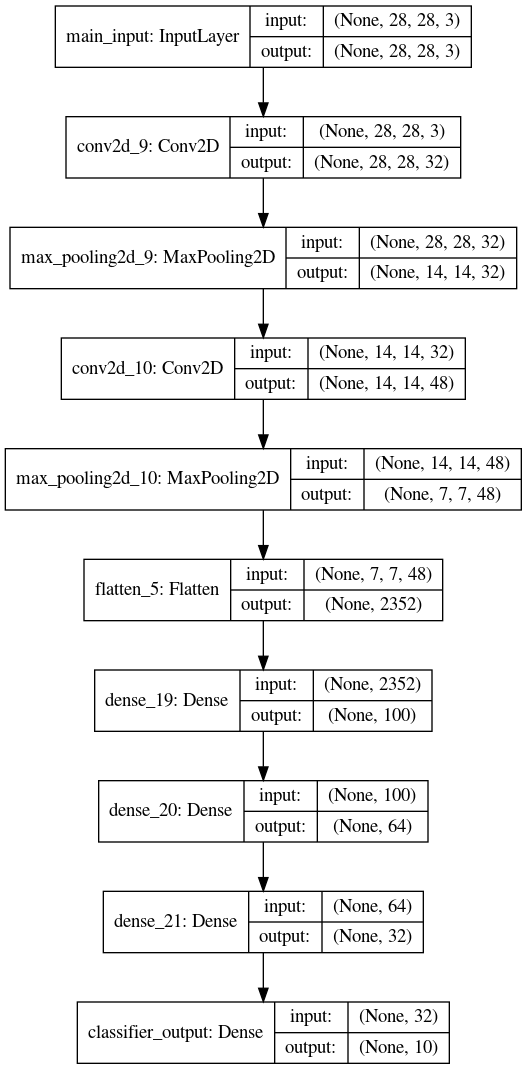

In [131]:
plot_model(source_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

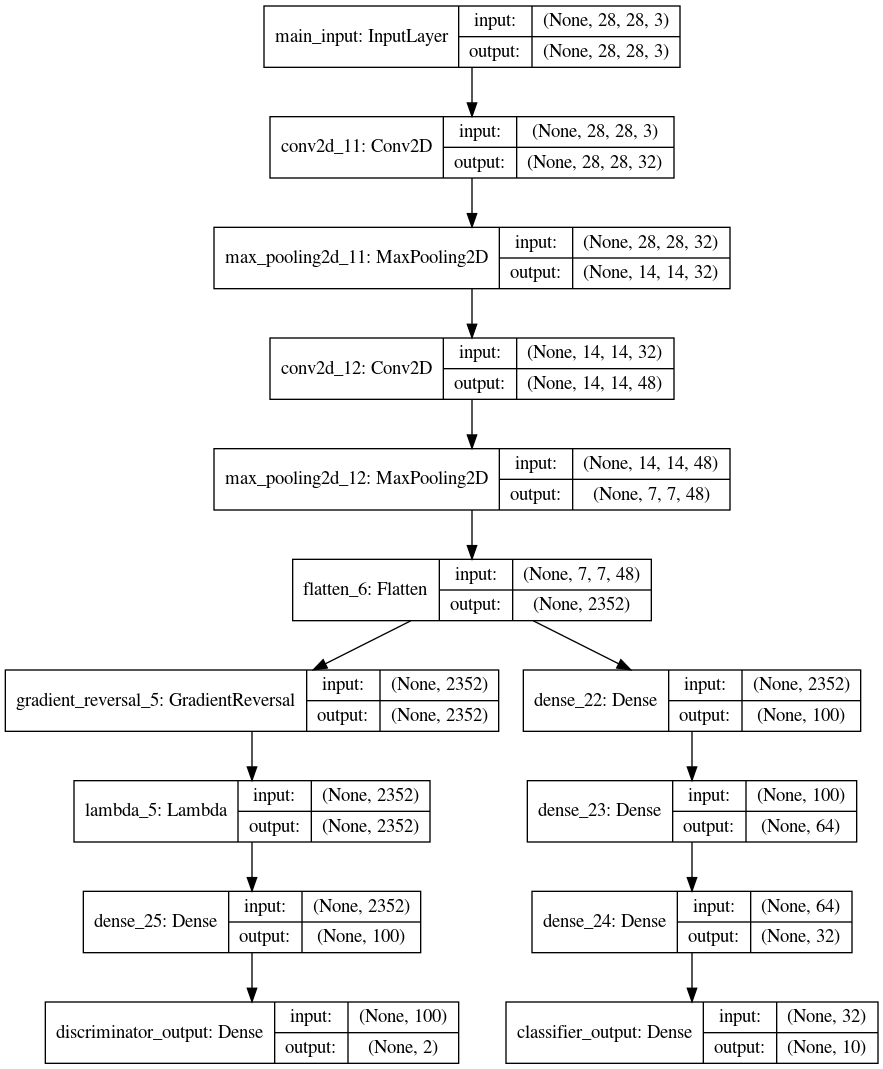

In [128]:
plot_model(dann_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [92]:
source_model.compile(optimizer=keras.optimizers.Adam(lr=0.0001)
              ,loss={'classifier_output': 'categorical_crossentropy'}
              ,metrics=['acc'])

dann_model.compile(optimizer=keras.optimizers.Adam(lr=0.0001)
              ,loss={'classifier_output': 'categorical_crossentropy'
                    ,'discriminator_output': 'binary_crossentropy'}
              ,metrics=['acc'])

In [ ]:
source_hist = source_model.fit(combined_train_imgs,combined_train_labels
                              ,epochs=100,batch_size=64)

dann_hist = dann_model.fit(combined_train_imgs,
                           [combined_train_domain,combined_train_labels]
                           ,epochs=100,batch_size=64)

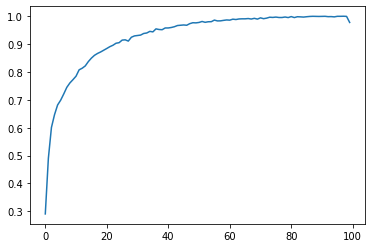

In [96]:
plt.plot(source_hist.history['acc'])

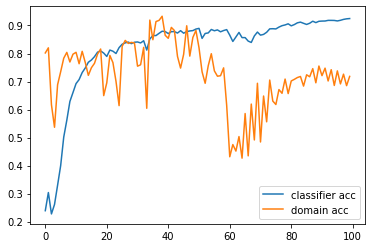

In [94]:
plt.plot(dann_hist.history['classifier_output_acc'],label='classifier acc')
plt.plot(dann_hist.history['discriminator_output_acc'],label='domain acc')
plt.legend()

In [110]:
source_acc = source_model.evaluate(testX,testY)
target_acc = source_model.evaluate(testDX,testY)
print(source_acc[-1],target_acc[-1])

500/500 [==============================] - 0s 172us/step
0.9319999814033508 0.7979999780654907


In [111]:
source_acc = dann_model.evaluate(testX,[testX_domain,testY])
source_pred = dann_model.predict(testX)
target_acc = dann_model.evaluate(testDX,[testDX_domain,testY])
target_pred = dann_model.predict(testDX)
print(source_acc[-1],target_acc[-1])

500/500 [==============================] - 0s 146us/step
0.9319999814033508 0.8420000076293945


100%|██████████| 1000/1000 [00:00<00:00, 4829.62it/s]


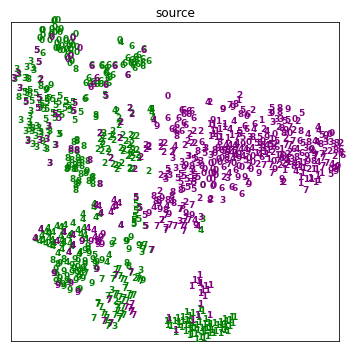

In [127]:
feature_model = keras.models.Model(source_model.input,source_model.get_layer('flatten_5').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(emb)
plot_embedding(source_only_tsne, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'source')

100%|██████████| 1000/1000 [00:00<00:00, 5035.60it/s]


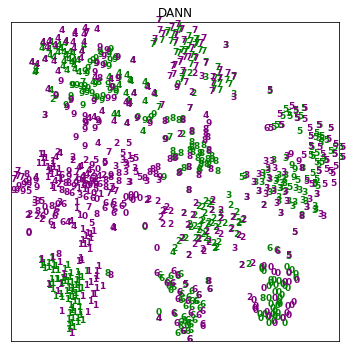

In [126]:
feature_model = keras.models.Model(dann_model.input,dann_model.get_layer('flatten_6').output)
emb = feature_model.predict(combined_test_imgs)
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
source_only_tsne = tsne.fit_transform(emb)
plot_embedding(source_only_tsne, combined_test_labels.argmax(1)
               ,combined_test_domain.argmax(1),'DANN')